## Aditya Jindal
## Batch W6
## Assignment10
## GradCAM Experiment 2 with VGG

Let's start with a pretrained VGG model

In [2]:
# Importing Libraries

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras import backend as K


Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [2]:
#Mounting drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Loading VGG model and our test image

model = VGG16(weights="imagenet")
model.summary()
from skimage import io
dog = io.imread("/content/gdrive/My Drive/EVA_Weights/tony_stark_with_glasses.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

W0703 17:44:38.049689 140551292274560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 17:44:38.075742 140551292274560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 17:44:38.080670 140551292274560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 17:44:38.115861 140551292274560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 17:44:39.968338 140551292274560 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer
4. Compute the gradient of the class output value with respect to the feature map
5. Pool the gradients over all the axies leaving out the channel dimension
6. Weigh the output feature map with the computed gradient values
7. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
8. Normalize the heat map to make the values between 0 and 1

In [0]:
# Defining GraCAM function

def gradCam(img, layer, channel_out):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(channel_out):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    
    return superimposed_img

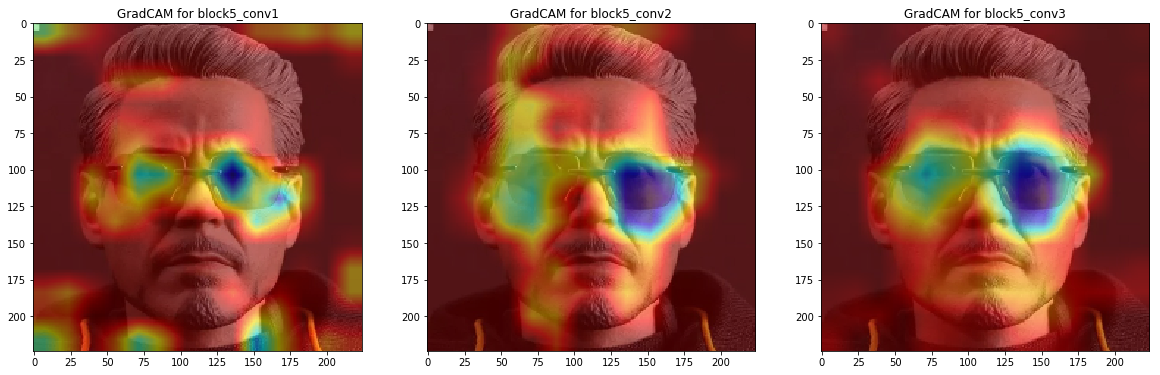

In [24]:
# Ploting the heatmap superimposed Gradcam for the last 3 layers

fig, ax = plt.subplots(1, 3, figsize = (20, 180))

for i in enumerate(ax):
    layerName = "block5_conv"+str(i[0]+1)
    grad_img = gradCam(dog, layerName, 512)
    i[1].set_title("GradCAM for "+ layerName)
    i[1].imshow(grad_img)

plt.show()

## Viewing Saliency Maps

In [1]:
!pip3 install scipy==1.1.0 --user

In [11]:
!pip uninstall vis
!pip uninstall keras-vis
!pip uninstall keras-vis-temp

Uninstalling keras-vis-0.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras_vis-0.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/vis/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/autogen.py
Proceed (y/n)? y
  Successfully uninstalled keras-vis-0.4.1


In [4]:
 !pip install git+https://github.com/raghakot/keras-vis.git -U

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-lx0d17gl
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-lx0d17gl
  Stored in directory: /tmp/pip-ephem-wheel-cache-at2gicop/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


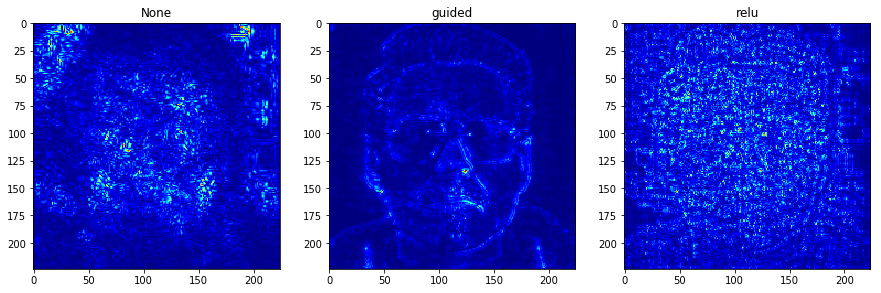

In [30]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
# from keras import activations

layer_idx = utils.find_layer_idx(model, 'predictions')

fig, ax = plt.subplots(1, 3, figsize = (15, 15))

for i, modifier in enumerate([None, 'guided', 'relu']):    
    # 836 is the imagenet index corresponding to `glasses`
    grads = visualize_saliency(model, layer_idx, filter_indices=836, 
                               seed_input=dog, backprop_modifier=modifier)
    # Lets overlay the heatmap onto original image.
    if(i==0):
      modifier = 'None'
    ax[i].set_title(modifier)
    ax[i].imshow(grads, cmap='jet')

## Part 2
### Explaining the rise in Receptive Field for the given model

#### J<sub>Out</sub> = J<sub>In</sub> * S   

####  J<sub>In</sub> = J<sub>Out</sub>

#### R<sub>Out</sub> = R<sub>In</sub> + (K-1) * J<sub>In</sub> 

---

#### Layer_1: Convolution 3×3×3 | Stride = 1 | Output = 128×128×96 

J<sub>in</sub> = 1,  J<sub>out</sub> = 1, K = 3, R<sub>in</sub> = 1, R<sub>out</sub> = **3**

---
#### Contracting Block 1
#### Layer_21: Convolution 3×3×3 | Stride = 2 | Output = 64×64×48 

J<sub>in</sub> = 1,  J<sub>out</sub> = 2, K = 3, R<sub>in</sub> = 3, R<sub>out</sub> = **5**

#### Layer_22: Convolution 3×3×3 | Stride = 1 | Output = 64×64×48 

J<sub>in</sub> = 2,  J<sub>out</sub> = 2, K = 3, R<sub>in</sub> = 5, R<sub>out</sub> = **9**

---
#### Contracting Block 2

#### Layer_31: Convolution 3×3×3 | Stride = 2 | Output = 32×32×24 

J<sub>in</sub> = 2,  J<sub>out</sub> = 4, K = 3, R<sub>in</sub> = 9, R<sub>out</sub> = **13**

#### Layer_32: Convolution 3×3×3| Stride = 1 | Output = 32×32×24 

J<sub>in</sub> = 4,  J<sub>out</sub> = 4, K = 3, R<sub>in</sub> = 13, R<sub>out</sub> = **21**

---
#### Contracting Block 3
#### Layer_41: Convolution 3×3×3 | Stride = 2 | Output = 16×16×12

J<sub>in</sub> = 4,  J<sub>out</sub> = 8, K = 3, R<sub>in</sub> = 21, R<sub>out</sub> = **29**

#### Layer_42: Convolution 3×3×3 | Stride = 1 | Output = 16×16×12

J<sub>in</sub> = 8,  J<sub>out</sub> = 8, K = 3, R<sub>in</sub> = 29, R<sub>out</sub> = **45**

### End of Contraction Rf = 45

## Visualising Layerwise Activations

In [25]:
!pip install keract

sunglasses (32.72009491920471)
input_6:0 (224, 224, 3) -> Skipped. First dimension is not 1.
block1_conv1_5/Relu:0 (1, 224, 224, 64) 


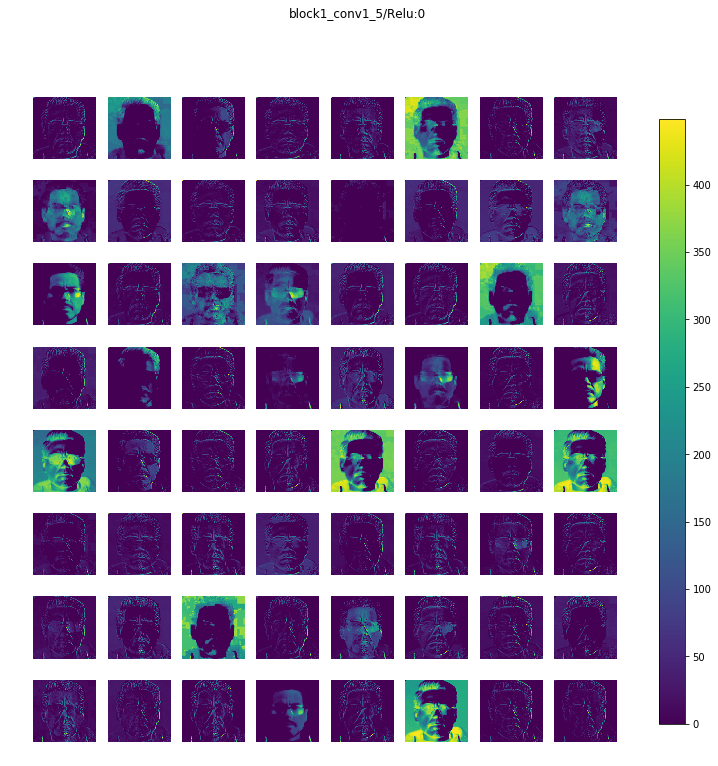

block1_conv2_5/Relu:0 (1, 224, 224, 64) 


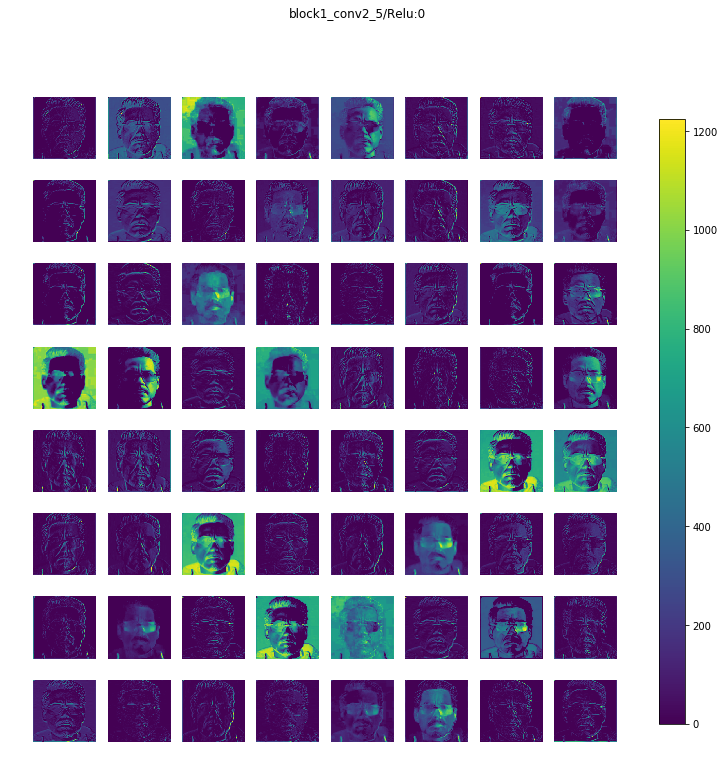

block1_pool_5/MaxPool:0 (1, 112, 112, 64) 


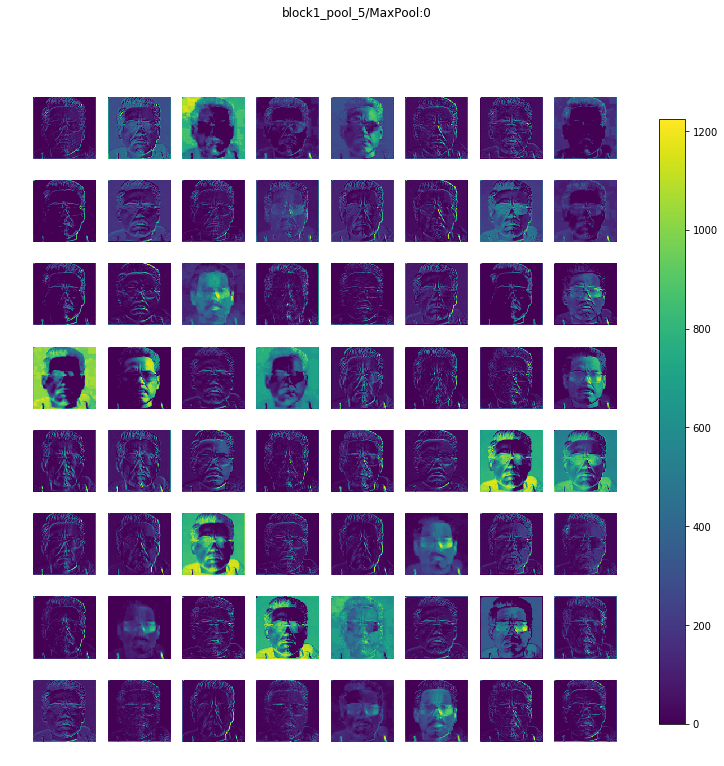

block2_conv1_5/Relu:0 (1, 112, 112, 128) 


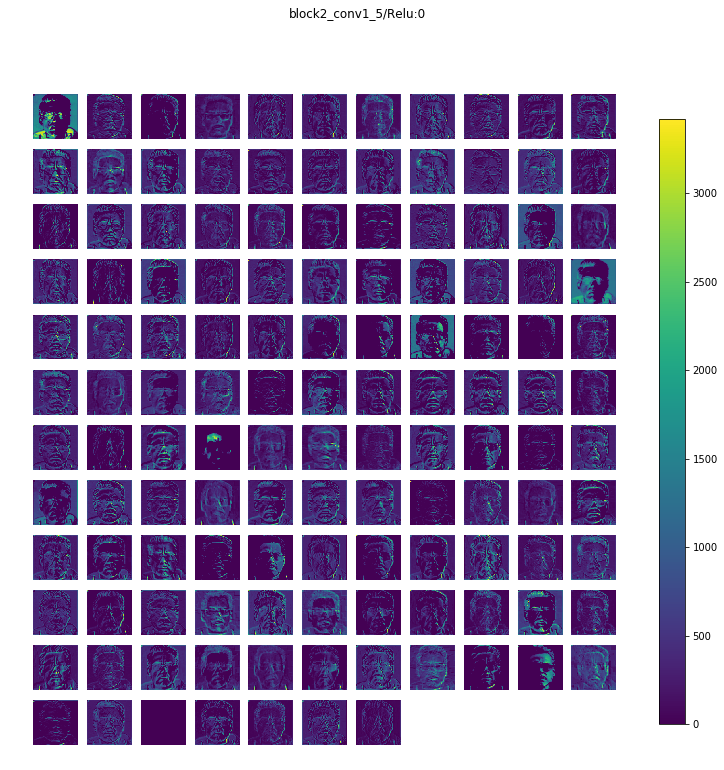

block2_conv2_5/Relu:0 (1, 112, 112, 128) 


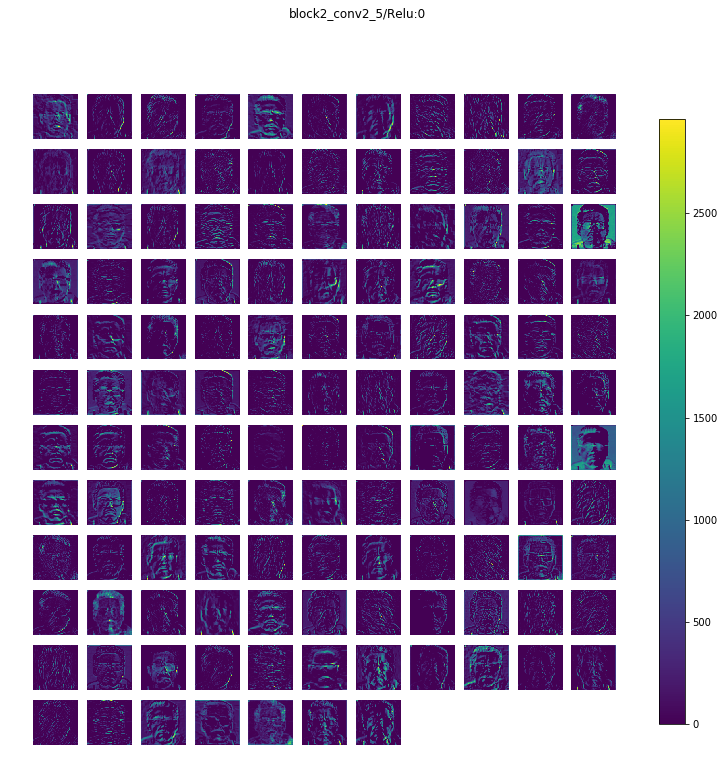

block2_pool_5/MaxPool:0 (1, 56, 56, 128) 


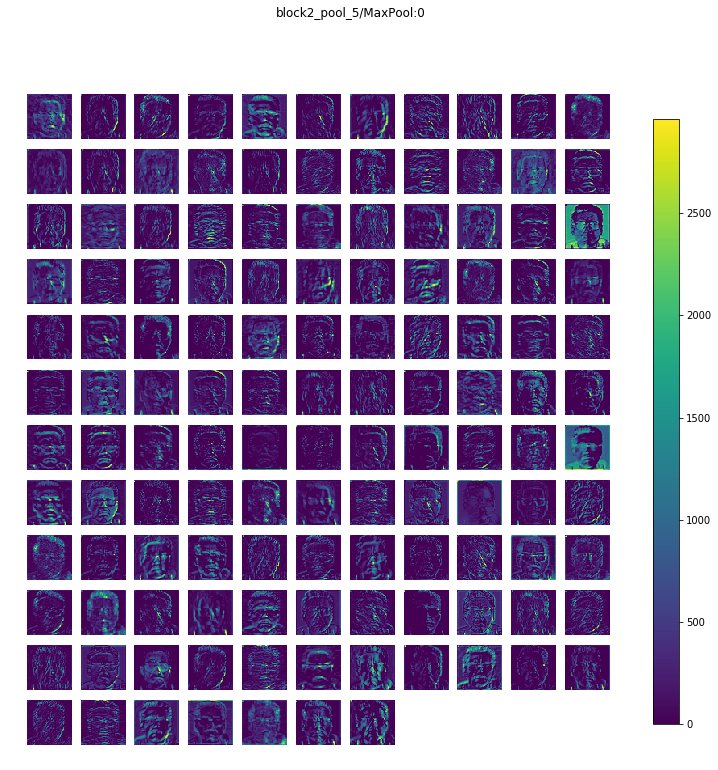

block3_conv1_5/Relu:0 (1, 56, 56, 256) 


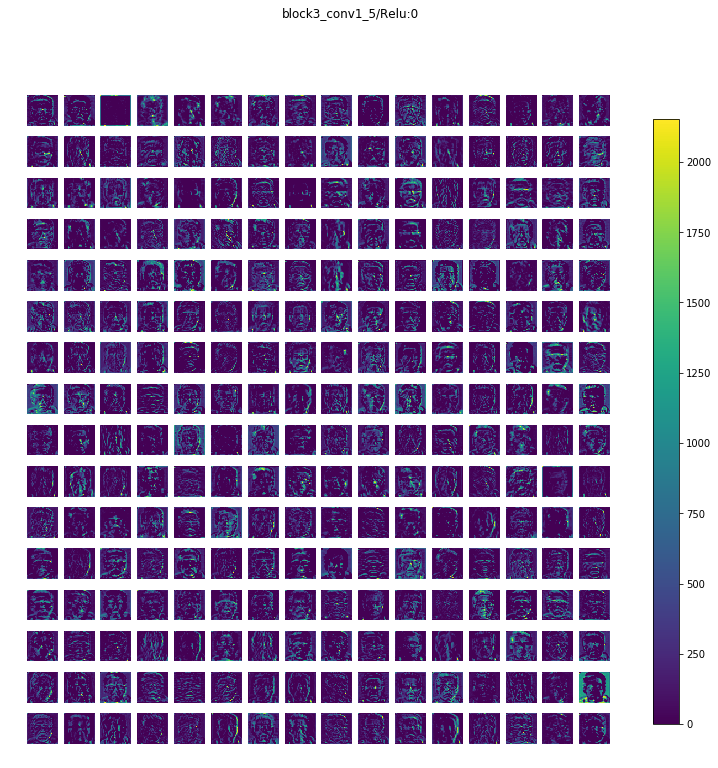

block3_conv2_5/Relu:0 (1, 56, 56, 256) 


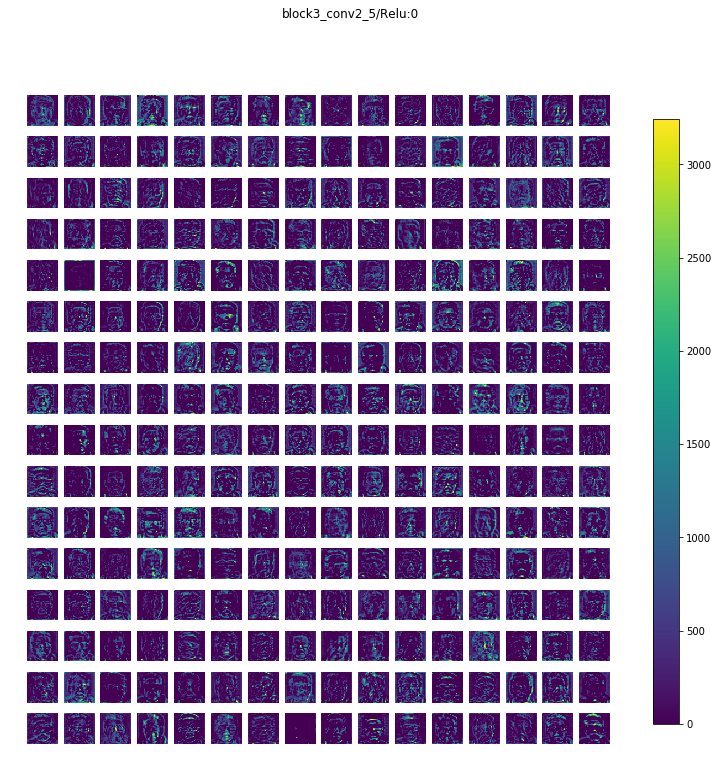

block3_conv3_5/Relu:0 (1, 56, 56, 256) 


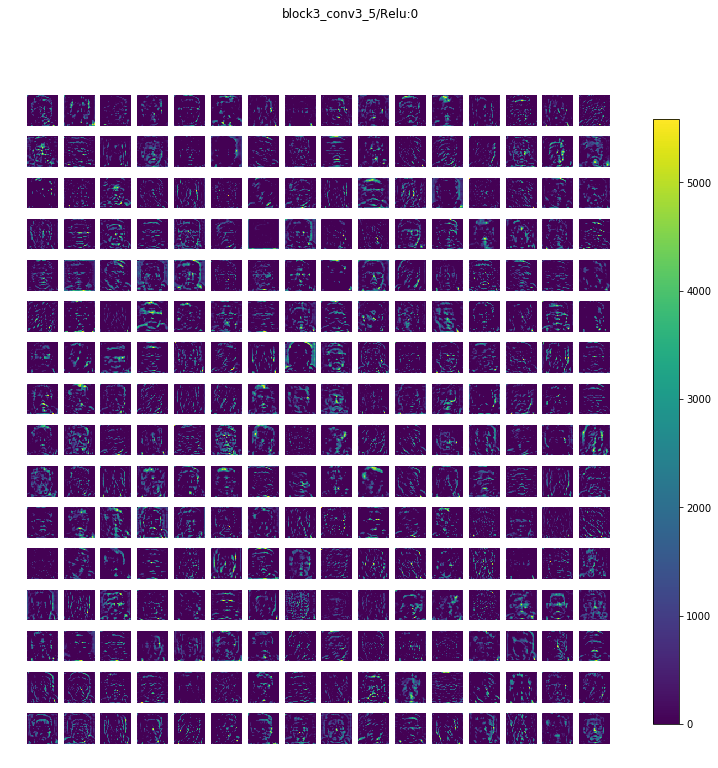

block3_pool_5/MaxPool:0 (1, 28, 28, 256) 


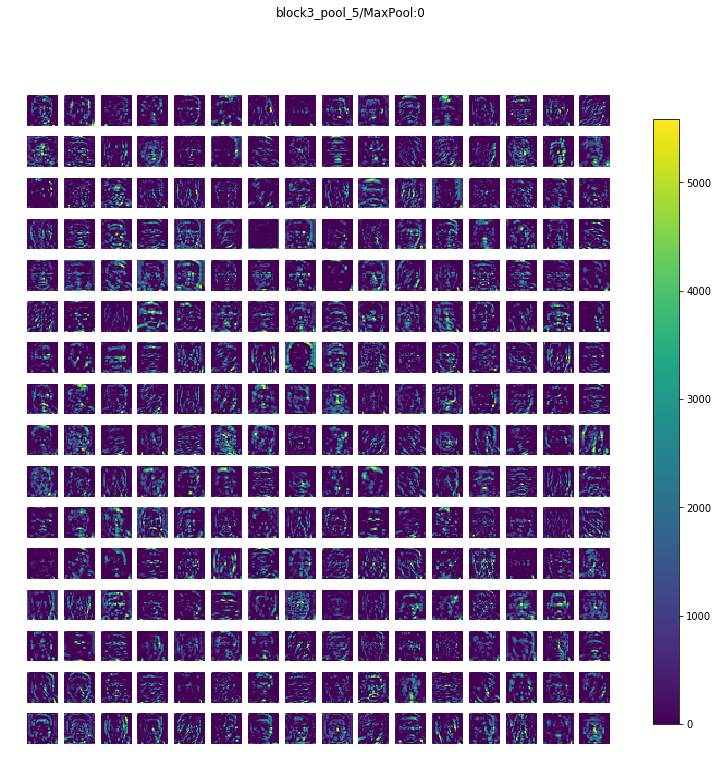

block4_conv1_5/Relu:0 (1, 28, 28, 512) 


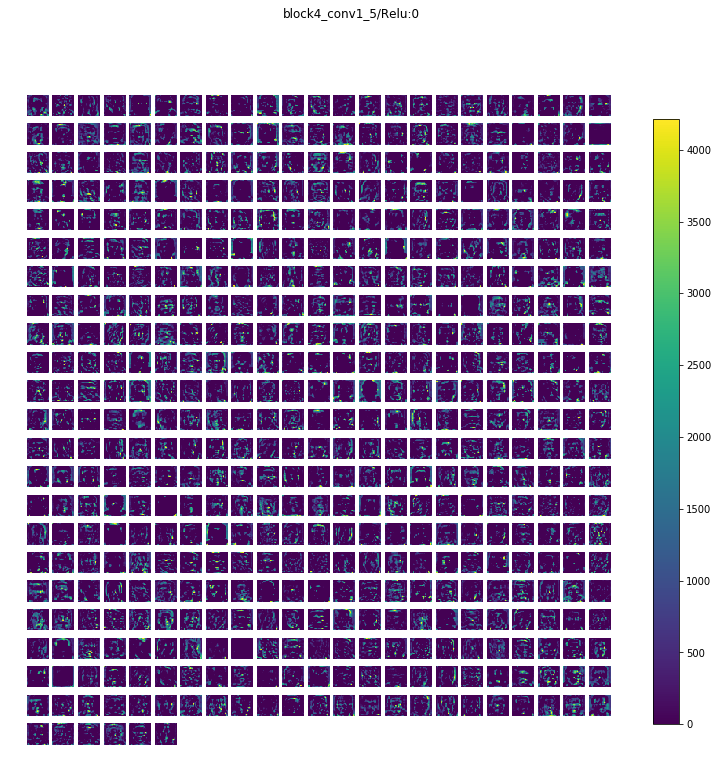

block4_conv2_5/Relu:0 (1, 28, 28, 512) 


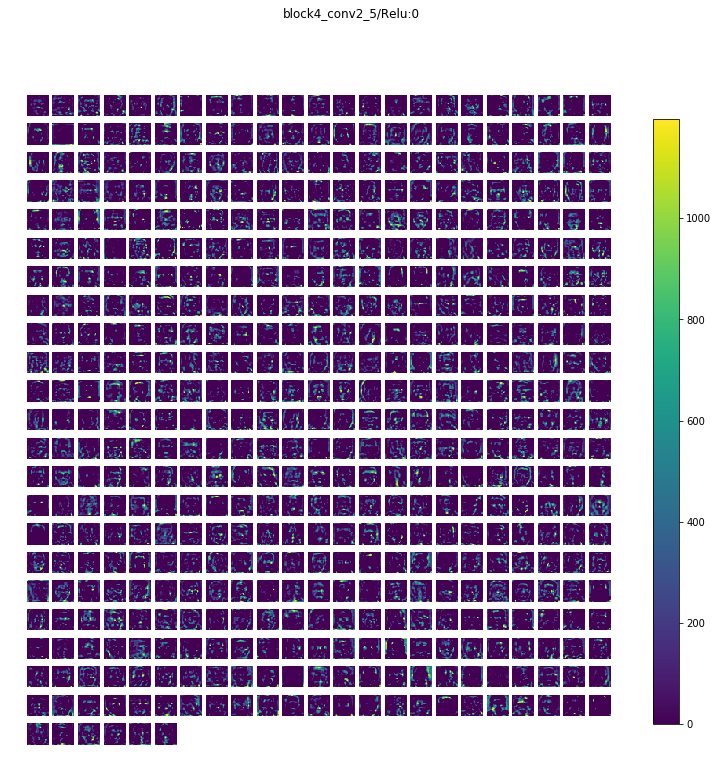

block4_conv3_5/Relu:0 (1, 28, 28, 512) 


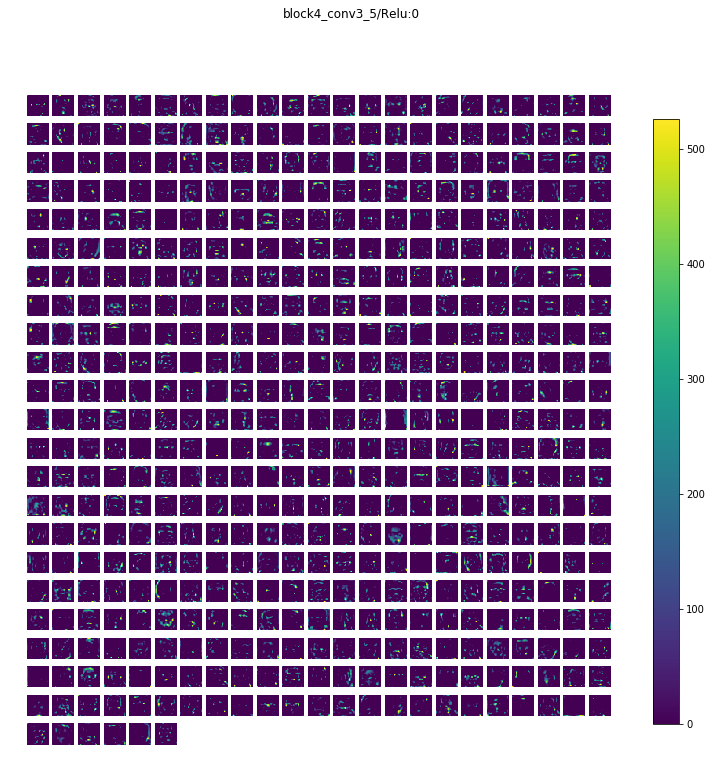

block4_pool_5/MaxPool:0 (1, 14, 14, 512) 


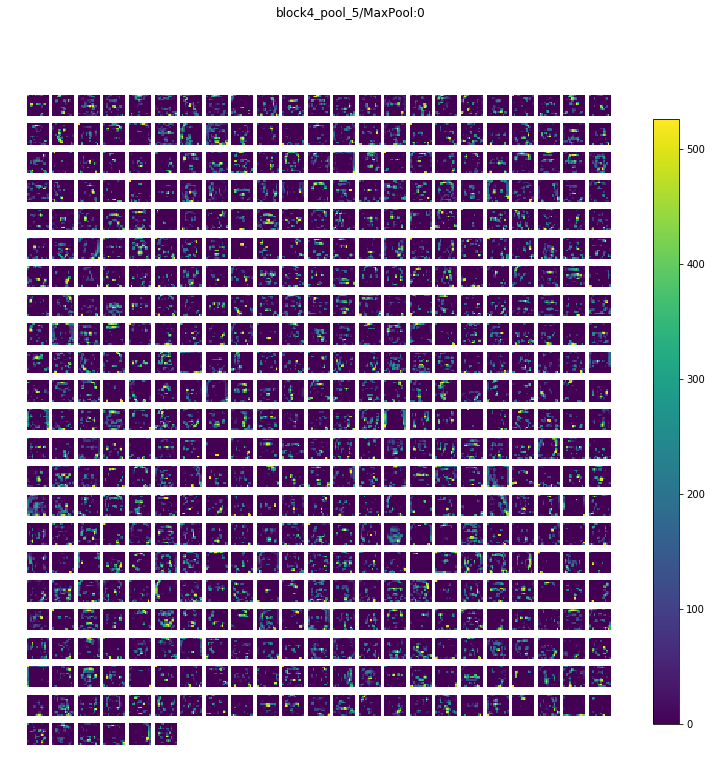

block5_conv1_5/Relu:0 (1, 14, 14, 512) 


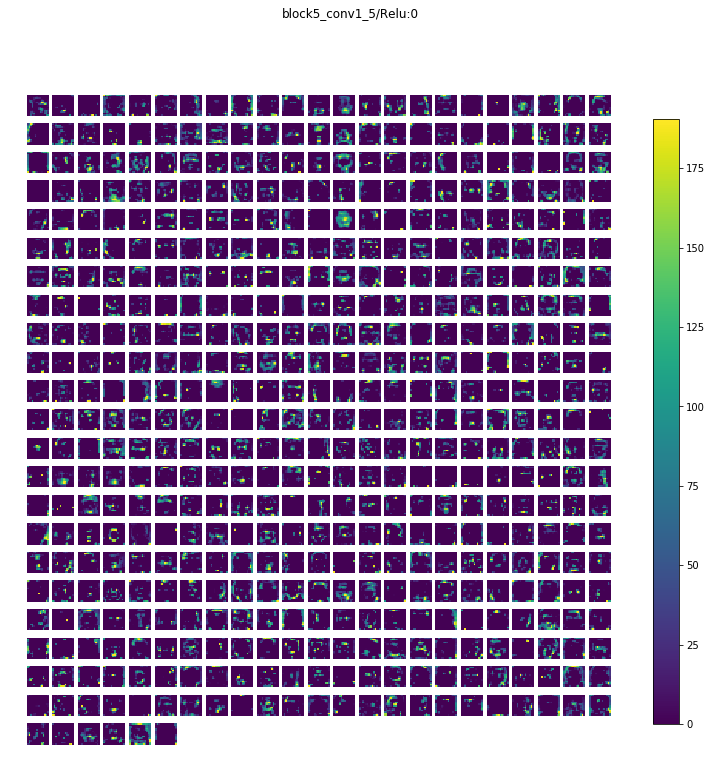

block5_conv2_5/Relu:0 (1, 14, 14, 512) 


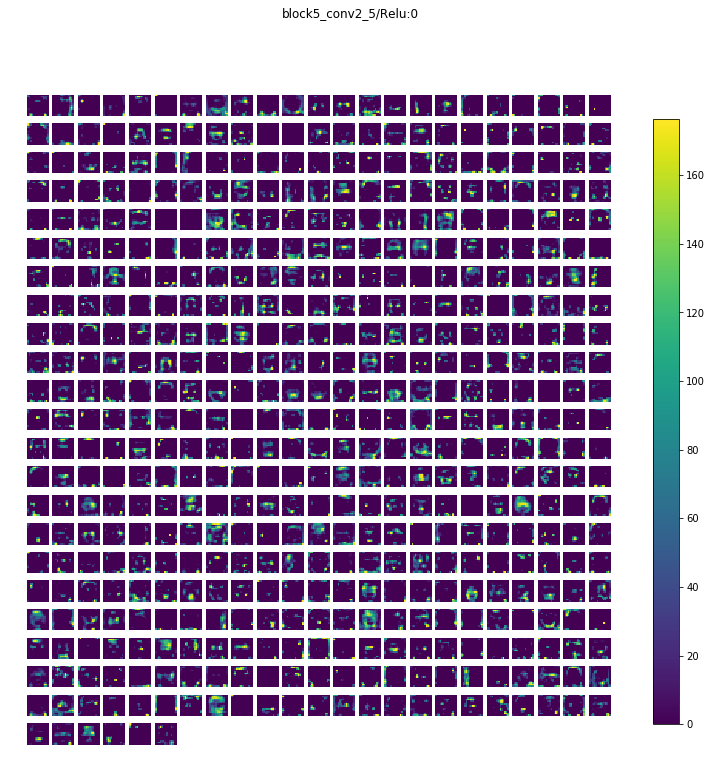

block5_conv3_5/Relu:0 (1, 14, 14, 512) 


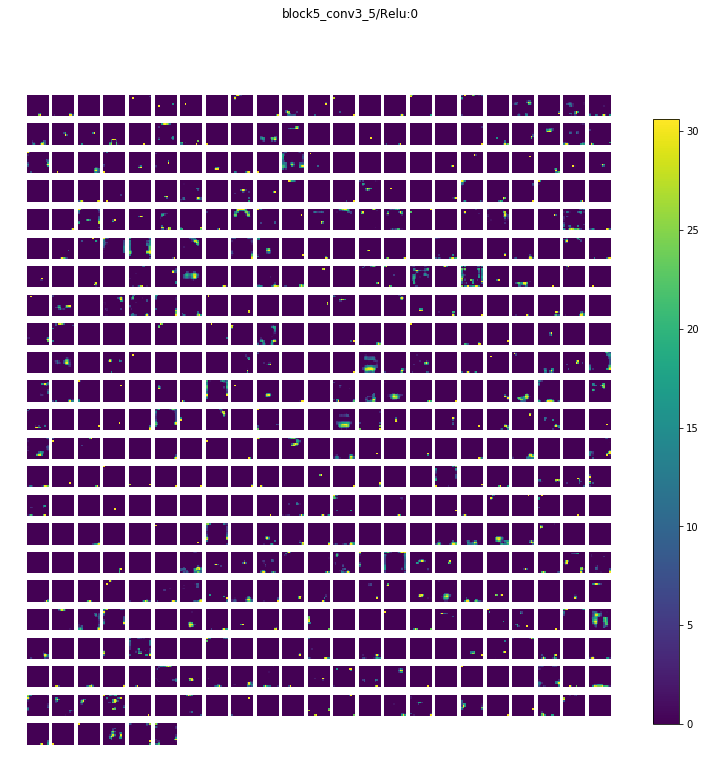

block5_pool_5/MaxPool:0 (1, 7, 7, 512) 


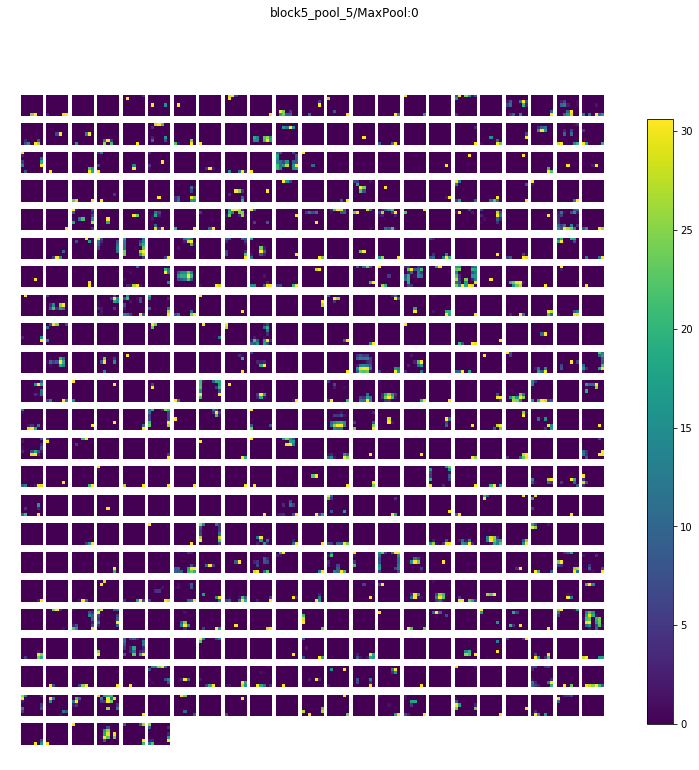

flatten_5/Reshape:0 (1, 25088) -> Skipped. 2D Activations.
fc1_5/Relu:0 (1, 4096) -> Skipped. 2D Activations.
fc2_5/Relu:0 (1, 4096) -> Skipped. 2D Activations.
predictions_5/Softmax:0 (1, 1000) -> Skipped. 2D Activations.


In [29]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

model = VGG16()

from PIL import Image
import requests
from io import BytesIO

url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = image.crop((0, 0, 690, 690))
image = image.resize((224,224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('{} ({})'.format(label[1], label[2] * 100))

import keract

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
activations = keract.get_activations(model, image)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)